In [2]:
import pandas as pd
import numpy as np

In [19]:
train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [4]:
train.time_id.nunique()

3830

<AxesSubplot:>

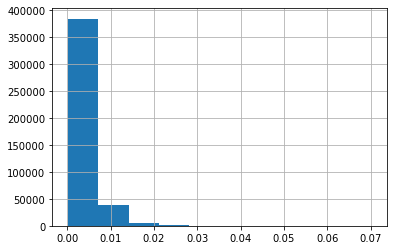

In [5]:
train.target.hist()

In [6]:
train.target.describe()

count    428932.000000
mean          0.003880
std           0.002936
min           0.000105
25%           0.002026
50%           0.003048
75%           0.004738
max           0.070321
Name: target, dtype: float64

In [10]:
train['log_target'] = np.log(train.target.to_numpy())

<AxesSubplot:>

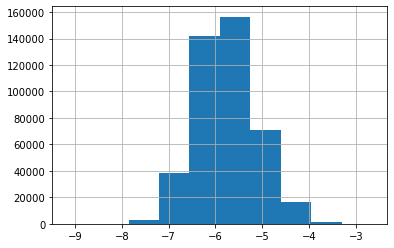

In [11]:
train.log_target.hist()

In [4]:
train_book = pd.read_parquet("../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0")
train_book

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28


In [3]:
train_book = pd.read_parquet("../input/book-ffill/book_train.parquet/stock_id=0")
train_book

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,2,1.001422,1.002301,1.001370,1.002353,3,100,2,100
3,5,3,1.001422,1.002301,1.001370,1.002353,3,100,2,100
4,5,4,1.001422,1.002301,1.001370,1.002353,3,100,2,100
...,...,...,...,...,...,...,...,...,...,...
2297995,32767,595,0.998275,0.998754,0.998179,0.998946,92,90,26,28
2297996,32767,596,0.998275,0.998754,0.998179,0.998946,92,90,26,28
2297997,32767,597,0.998275,0.998754,0.998179,0.998946,92,90,26,28
2297998,32767,598,0.998275,0.998754,0.998179,0.998946,92,90,26,28


In [17]:
# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def log_return(series):
    return np.log(series).diff()

In [16]:
train_book['wap1'] = calc_wap1(train_book)
train_book['wap2'] = calc_wap2(train_book)
train_book.groupby(['time_id'])['wap1']

In [18]:
log_return(train_book['wap1'])

0              NaN
1         0.000014
2         0.000000
3        -0.000005
4         0.000000
            ...   
917548    0.000434
917549    0.000001
917550    0.000000
917551    0.000001
917552    0.000000
Name: wap1, Length: 917553, dtype: float32

In [22]:
train_trade = pd.read_parquet("../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0")
train_trade

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
...,...,...,...,...,...
123438,32767,471,0.998659,200,3
123439,32767,517,0.998515,90,1
123440,32767,523,0.998563,1,1
123441,32767,542,0.998803,90,4


In [30]:
intime_stds = train_trade.groupby('time_id')['price'].std()
np.histogram(intime_stds)

(array([3589,  213,   17,    5,    4,    0,    1,    0,    0,    1]),
 array([0.        , 0.00218926, 0.00437852, 0.00656778, 0.00875703,
        0.01094629, 0.01313555, 0.01532481, 0.01751407, 0.01970333,
        0.02189259]))

In [26]:
np.std(train_trade.groupby('time_id')['price'].mean().to_numpy())

0.0034378993